In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 4090
GPU memory: 24210.31 MB


In [3]:
class LinearNet_G(nn.Module):
    def __init__(self, NL, NN, input, output):     ## NL是有多少层隐藏层, NN是每层的神经元数量
        super(LinearNet_G, self).__init__()
        self.input_layer = nn.Linear(input, NN, bias=True)
        self.hidden_layer = nn.ModuleList([nn.Linear(NN, NN, bias=True) for i in range(NL)])
        self.output_layer = nn.Linear(NN, output, bias=True)

    def forward(self, x):
        o = self.act(self.input_layer(x))
        for i, li in enumerate(self.hidden_layer):  
            o = self.act(li(o))
        out = self.output_layer(o)
        return out

    def act(self, x):
        # return torch.tanh(x)
        return x  
    
class DeepOnet_G(nn.Module):
    def __init__(self, NL, NN, input, output, temp):     ## NL是有多少层隐藏层, NN是每层的神经元数量
        super(DeepOnet_G, self).__init__()
        self.f_layer = LinearNet_G(NL, NN, input, temp)
        self.tau_layer = torch.nn.Sequential(torch.nn.Linear(1, NN), nn.Tanh(), torch.nn.Linear(NN, NN), nn.Tanh(), torch.nn.Linear(NN, NN), nn.Tanh(), torch.nn.Linear(NN, temp))
        self.out_layer = LinearNet_G(NL, NN, temp, output)

    def forward(self, f, tau):
        # return self.out_layer(self.f_layer(f) * self.tau_layer(1 / tau))
        return self.out_layer(self.f_layer(f) * self.tau_layer(torch.sqrt(tau)))

In [4]:
class MLP_bd(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP_bd, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet_bd(torch.nn.Module):
    def __init__(self, n_g, n_h, n_hidden, n_layers):
        super(DeepONet_bd, self).__init__()
        self.for_tau = MLP_bd(1, n_g, n_hidden, n_layers)
        self.for_g_1 = torch.nn.Linear(n_g, n_hidden)
        self.for_g_2 = torch.nn.Linear(n_hidden, n_h)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

In [5]:
def generate_flower_points(n, plot):
    theta = np.linspace(0, 2 * np.pi, 8 * n, endpoint=False)  # 均匀分布的角度
    r = 0.6 * (1 + 0.25 * np.sin(6 * theta))  # 计算极径
    x_boundary = r * np.cos(theta)
    y_boundary = r * np.sin(theta)
    boundary_points = np.column_stack((x_boundary, y_boundary))
    
    t_boundary = np.zeros((len(boundary_points), 1))
    for i in range(0, len(boundary_points)):
        t_boundary[i] = theta[i]
    
    x_vals = np.linspace(-1, 1, n + 1)
    y_vals = np.linspace(-1, 1, n + 1)
    xx, yy = np.meshgrid(x_vals, y_vals)
    interior_candidates = np.column_stack((xx.ravel(), yy.ravel()))
    
    r_candidate = np.sqrt(interior_candidates[:, 0]**2 + interior_candidates[:, 1]**2)
    theta_candidate = np.arctan2(interior_candidates[:, 1], interior_candidates[:, 0])
    r_max = 0.6 * (1 + 0.25 * np.sin(6 * theta_candidate))
    interior_points = interior_candidates[r_candidate <= 0.98 * r_max]
    
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(interior_points[:, 0], interior_points[:, 1], color='blue', label='Interior Points', s=10)
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', label='Boundary Points', s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Flower-Shaped Region Points")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    
    return (2 * np.pi) / (8 * n), t_boundary, boundary_points, interior_points

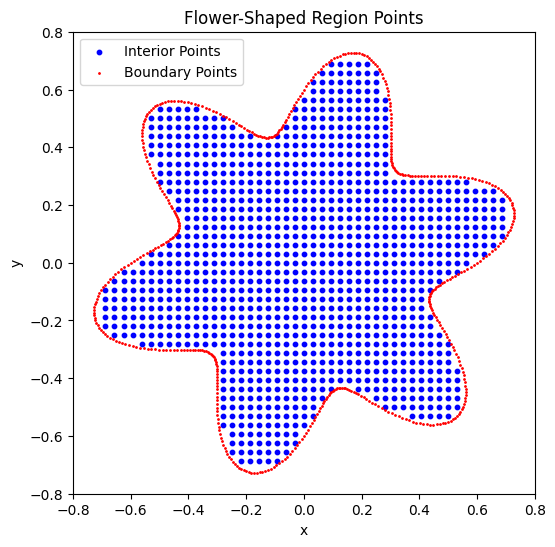

In [6]:
N = 64
h, s_for_integral, x_bd, x_interior = generate_flower_points(N, True)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_pt = torch.from_numpy(x_bd).clone().float().to(device)
x_interior_pt = torch.from_numpy(x_interior).clone().float().to(device)

x_pt = torch.zeros((N + 1) * (N + 1), 2).to(device)
for i in range(N + 1):
    for j in range(N + 1):
        x_pt[i * (N + 1) + j, 0] = -1 + 2 * j / N 
        x_pt[i * (N + 1) + j, 1] = -1 + 2 * i / N  

In [7]:
n_int = len(x_interior)
netF = DeepOnet_G(NL = 2, NN = n_int, input = n_int, output = n_int, temp = 2 * n_int).to(device)
netF.load_state_dict(torch.load("./GreenNet/net.pth", map_location = device, weights_only=True))

<All keys matched successfully>

In [8]:
netg = DeepONet_bd(N * 8, N * 8, N * 8, 2).to(device)
netg.load_state_dict(torch.load("./BINet+OL/net.pth", map_location = device, weights_only=True))

<All keys matched successfully>

In [9]:
# taus = [0.05, 1 / 15, 0.1]
# taus = [1/10, 1/11, 1/12, 1/13, 1/14, 1/15, 1/16, 1/17, 1/18, 1/19, 1/20]
taus = [0.05, 0.075, 0.1]


from scipy.special import kv, kvp

def get_point3(theta):
    temp1 = 0.6 * (1 + 0.25 * np.sin(6 * theta))

    x = temp1 * np.cos(theta)
    y = temp1 * np.sin(theta)

    temp2 = 0.6 + 0.15 * np.sin(6 * theta)

    dx = -temp2 * np.sin(theta) + 0.9 * np.cos(theta) * np.cos(6 * theta)
    dy = temp2 * np.cos(theta) + 0.9 * np.sin(theta) * np.cos(6 * theta)

    temp3 = -5.55 * np.sin(6 * theta) - 0.6
    ddx = temp3 * np.cos(theta) - 1.8 * np.sin(theta) * np.cos(6 * theta)
    ddy = temp3 * np.sin(theta) + 1.8 * np.cos(theta) * np.cos(6 * theta)

    return x, y, dx, dy, ddx, ddy

def kernel_int(tau, x, s):
    x1, x2 = x[0], x[1]
    
    x1_s, x2_s, dx1_s, dx2_s, ddx1_s, ddx2_s = get_point3(s)

    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kvp(0, r / np.sqrt(tau), n=1) * (dx2_s * (x1_s - x1) - dx1_s * (x2_s - x2)) / (np.sqrt(tau) * r)
    return result

kernels_for_int = torch.zeros(len(taus), len(x_interior), len(x_bd))
for k in range(len(taus)):
    for i in range(len(x_interior)):
        for j in range(len(x_bd)):
            kernels_for_int[k, i, j] = h * kernel_int(taus[k], x_interior[i, :], s_for_integral[j, 0])

def predict_u_int(net, tau, g):      # tau: scalar, g: (batch_size, n_bd)
    flag = 0
    for i in range(len(taus)):
        if np.abs(tau - taus[i]) < 1e-6:
            kernel = kernels_for_int[i, :, :]
            flag = 1
            # print(taus[i])
    
    if flag == 0 and tau > 0:
        kernel = torch.zeros(len(x_interior), len(s_for_integral))
        for i in range(len(x_interior)):
            for j in range(len(s_for_integral)):
                kernel[i, j] = h * kernel_int(tau, x_interior[i, :], s_for_integral[j, 0])
    else:
        exit("The value of tau is illegal!")

    kernel = kernel.to(device)

    result = 0.5 / (np.pi) * kernel @ net(tau, g).T
    return result.T

In [10]:
x = torch.linspace(-1, 1, 65)
y = torch.linspace(-1, 1, 65)
X, Y = torch.meshgrid(x, y, indexing='ij')  # X, Y形状均为(65, 65)
R = torch.sqrt(X**2 + Y**2)
Theta = torch.atan2(Y, X)
r_boundary = 0.6 * (1 + 0.25 * torch.sin(6 * Theta))
mask = R <= 0.98 * r_boundary

def filter_tensor(input_tensor, mask):
    m = input_tensor.shape[0]
    mask_flat = mask.reshape(-1)  # (65*65,)
    input_flat = input_tensor.reshape(m, -1)  # (m, 65*65)
    output = input_flat[:, mask_flat]  # (m, n)
    return output

def inverse_filter_tensor(compressed_tensor, mask, fill_value=0):
    m = compressed_tensor.shape[0]
    total_points = (N + 1) * (N + 1)
    
    output_flat = torch.full((m, total_points), fill_value, dtype=compressed_tensor.dtype).to(device)
    
    mask_flat = mask.reshape(-1)
    active_indices = torch.where(mask_flat)[0]  
    
    output_flat[:, active_indices] = compressed_tensor
    
    output = output_flat.reshape(m, (N + 1), (N + 1))
    return output

def computeErrors(u_exact, u_pre, printOrNot):
    if isinstance(u_exact, np.ndarray):
        u_exact = torch.from_numpy(u_exact)
    if isinstance(u_pre, np.ndarray):
        u_pre = torch.from_numpy(u_pre)
    
    error = u_exact - u_pre
    l2_norm_abs = torch.norm(error, p=2).item() / torch.sqrt(torch.tensor(error.numel(), dtype=torch.float))
    max_norm_abs = torch.norm(error, p=float('inf')).item()
    l2_norm_rel = torch.norm(error, p=2).item() / torch.norm(u_exact, p=2).item()
    max_norm_rel = torch.norm(error, p=float('inf')).item() / torch.norm(u_exact, p=float('inf')).item()  
    
    l2_norm_rel_percent = l2_norm_rel * 100
    max_norm_rel_percent = max_norm_rel * 100
    
    if printOrNot == True:
        print(f"Absolute L2 Norm Error: {l2_norm_abs:.6f}")
        print(f"Absolute Max Norm Error: {max_norm_abs:.6f}")
        print(f"Relative L2 Norm Error: {l2_norm_rel_percent:.4f}%")
        print(f"Relative Max Norm Error: {max_norm_rel_percent:.4f}%")

    return l2_norm_rel

def petal_curve(theta):
    x = 0.6 * (1 + 0.25 * np.sin(6 * theta)) * np.cos(theta)
    y = 0.6 * (1 + 0.25 * np.sin(6 * theta)) * np.sin(theta)
    return x, y

petal_theta = np.linspace(0, 2*np.pi, 1000)
petal_x, petal_y = petal_curve(petal_theta)

def plotSolutions(u_exact, u_pre, tau, t):
    if isinstance(u_exact, torch.Tensor):
        u_exact = u_exact.cpu().detach().numpy()
    if isinstance(u_pre, torch.Tensor):
        u_pre = u_pre.cpu().detach().numpy()

    u_exact = u_exact.reshape((N + 1, N + 1))
    u_pre = u_pre.reshape((N + 1, N + 1))
    error = u_exact - u_pre

    for i in range(N + 1):
        for j in range(N + 1):
            if mask[i, j] == False:
                u_exact[i, j] = np.nan
                u_pre[i, j] = np.nan
                error[i, j] = np.nan

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    cax1 = axs[0].imshow(np.ma.masked_invalid(u_pre), cmap='viridis', extent=[-1, 1, -1, 1], origin='lower')
    axs[0].plot(petal_x, petal_y, linewidth = 8, color='white')
    axs[0].set_title('Predicted Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(np.ma.masked_invalid(u_exact), cmap='viridis', extent=[-1, 1, -1, 1], origin='lower')
    axs[1].plot(petal_x, petal_y, linewidth = 8, color='white')
    axs[1].set_title('Exact Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(np.ma.masked_invalid(error), cmap='viridis', extent=[-1, 1, -1, 1], origin='lower')
    axs[2].plot(petal_x, petal_y, linewidth = 8, color='white')
    axs[2].set_title('Error at time ' + str(round(t, 4)) + ' with \u03c4 = ' + str(round(tau, 4)))
    fig.colorbar(cax3, ax=axs[2])

    plt.show()

In [11]:
def U(t, x):
    x1 = x[:, 0].view(1, -1)
    x2 = x[:, 1].view(1, -1)
    return np.exp(-t) * torch.sin(np.sqrt(2)/2 * x1 + np.sqrt(2)/2 * x2)
    # return np.exp(-t) * torch.sin(x1) * torch.sin(x2) 
    # return torch.sin(x1) * 0 + 1

def solveByNEKM(f, g, tau):      # f: (N + 1, N + 1), g: (1, 8*N), tau is a scalar
    tau_ = torch.zeros(1, 1) + tau
    f = filter_tensor(f.view(1, N + 1, N + 1), mask)
    u1 = netF(f, tau_.to(device))
    u2 = predict_u_int(netg, tau, g)
    # print(u1)
    # print(u2)
    return inverse_filter_tensor((u1 + u2).view(1, -1), mask).view(N + 1, N + 1)


def testNEKM(tau, n):
    u_pre_now = U(0, x_pt)
    steps = []
    errors = []

    for i in range(n):
        u_pre_now = solveByNEKM(u_pre_now, U(tau * (i + 1), x_bd_pt).view(1, -1), tau)
        u_exact = inverse_filter_tensor(U(tau * (i + 1), x_interior_pt), mask).view(N + 1, N + 1)
        # u_pre_now = inverse_filter_tensor(filter_tensor(u_pre_now.view(-1, N + 1, N + 1), mask), mask).view(N + 1, N + 1)
        # u_exact = inverse_filter_tensor(filter_tensor(u_exact.view(-1, N + 1, N + 1), mask), mask).view(N + 1, N + 1)
        steps.append(tau * (i + 1))
        errors.append(computeErrors(u_exact, u_pre_now, 0))

        if ((i + 1) % 1 == 0):
            plotSolutions(u_exact, u_pre_now, tau, tau * (i + 1))
            computeErrors(u_exact, u_pre_now, 1)

    # plt.figure(dpi=600,facecolor='white')
    # plt.plot(steps, errors)
    # plt.xlabel('time')
    # plt.ylabel('Errors')
    # plt.title("Relative L2 errors at each time steps")
    # for x,y in zip(steps, errors):
    #     plt.text(x,y,round(y,6),fontdict={'fontsize':6})

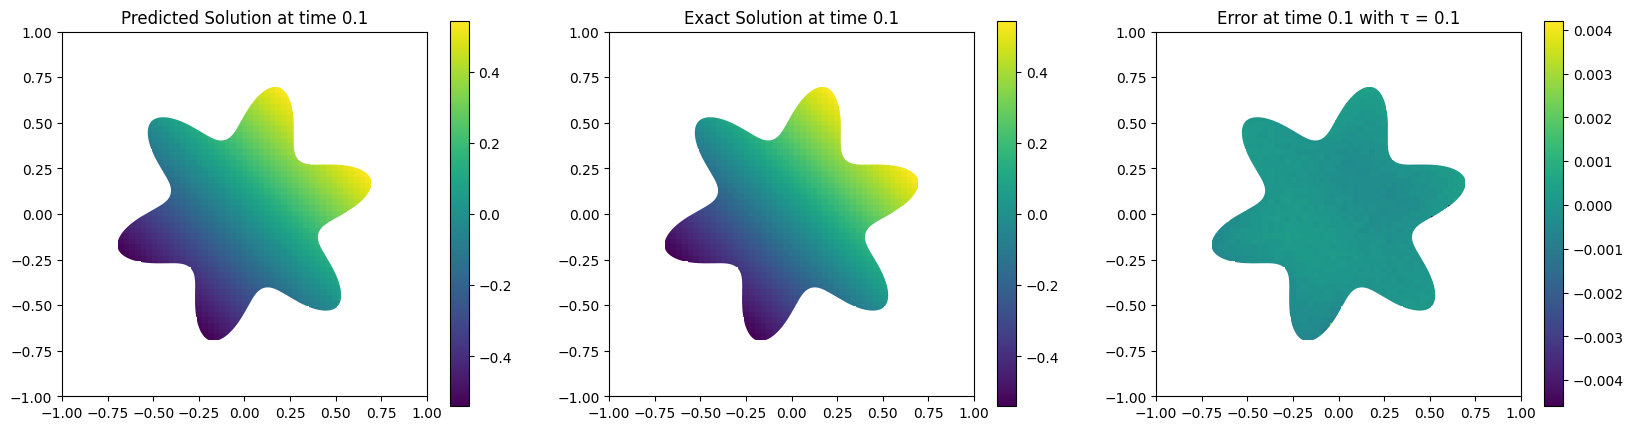

Absolute L2 Norm Error: 0.000189
Absolute Max Norm Error: 0.004601
Relative L2 Norm Error: 0.1310%
Relative Max Norm Error: 0.8505%


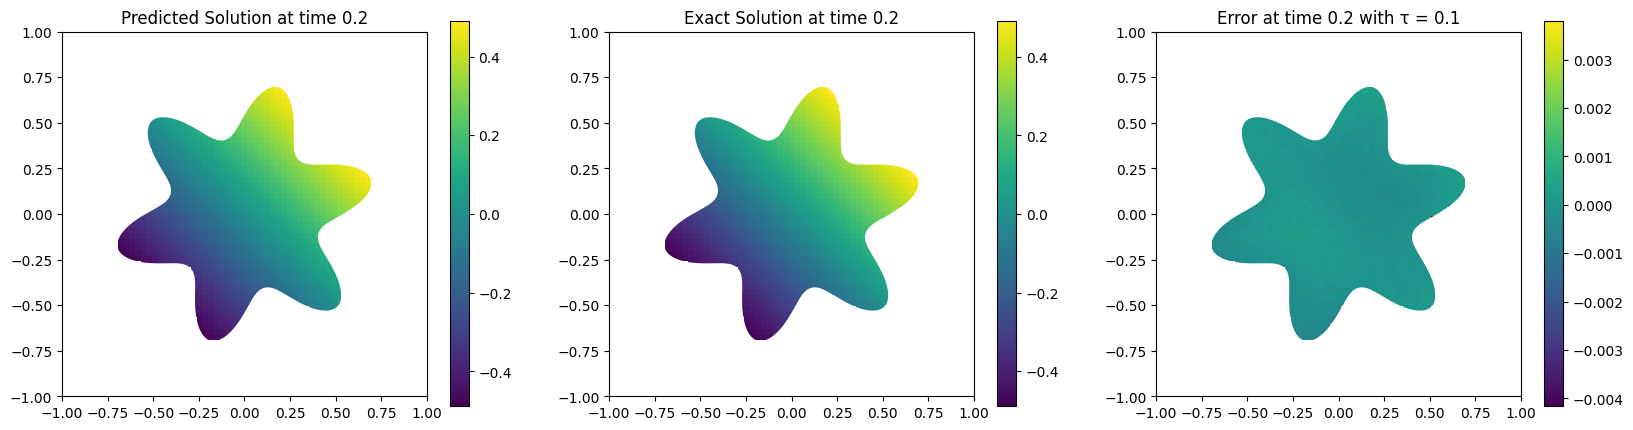

Absolute L2 Norm Error: 0.000175
Absolute Max Norm Error: 0.004168
Relative L2 Norm Error: 0.1342%
Relative Max Norm Error: 0.8516%


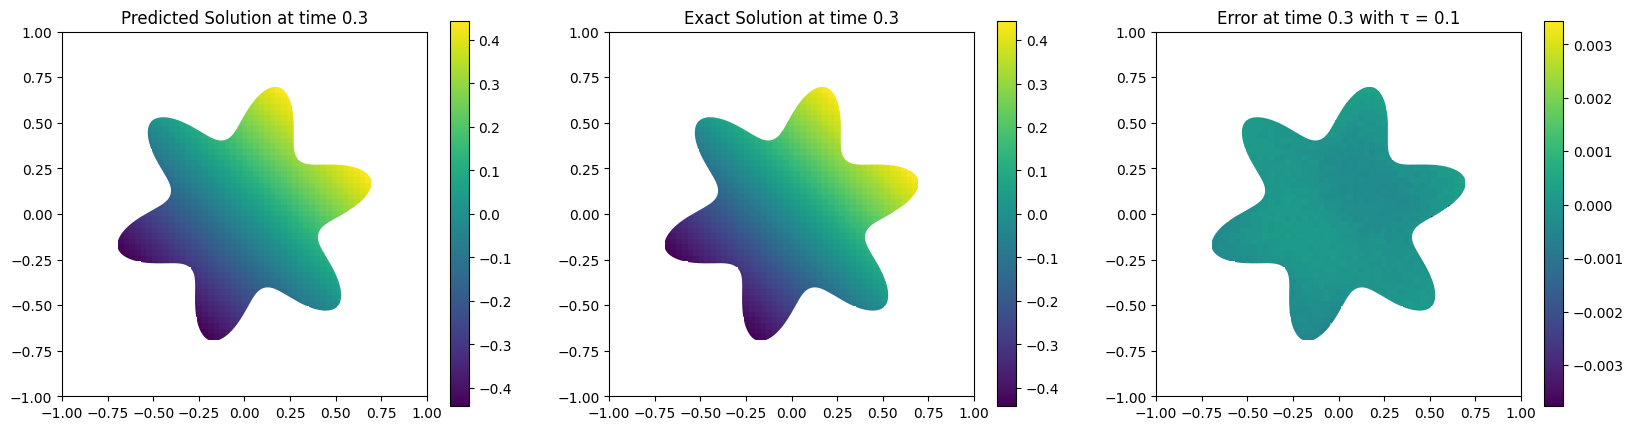

Absolute L2 Norm Error: 0.000159
Absolute Max Norm Error: 0.003775
Relative L2 Norm Error: 0.1351%
Relative Max Norm Error: 0.8523%


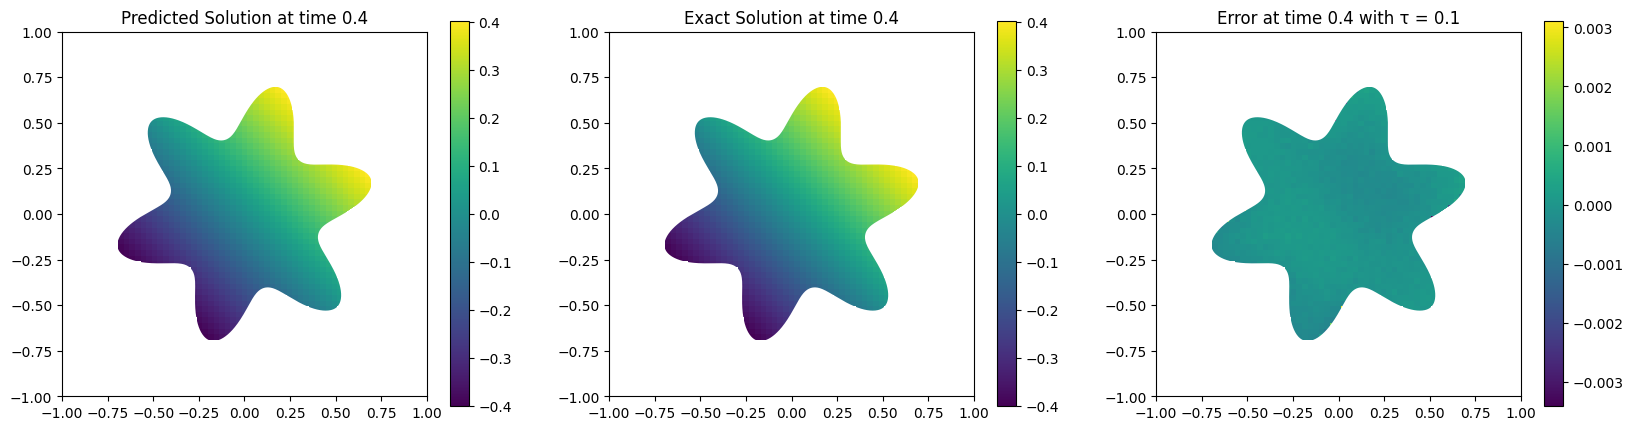

Absolute L2 Norm Error: 0.000145
Absolute Max Norm Error: 0.003419
Relative L2 Norm Error: 0.1354%
Relative Max Norm Error: 0.8531%


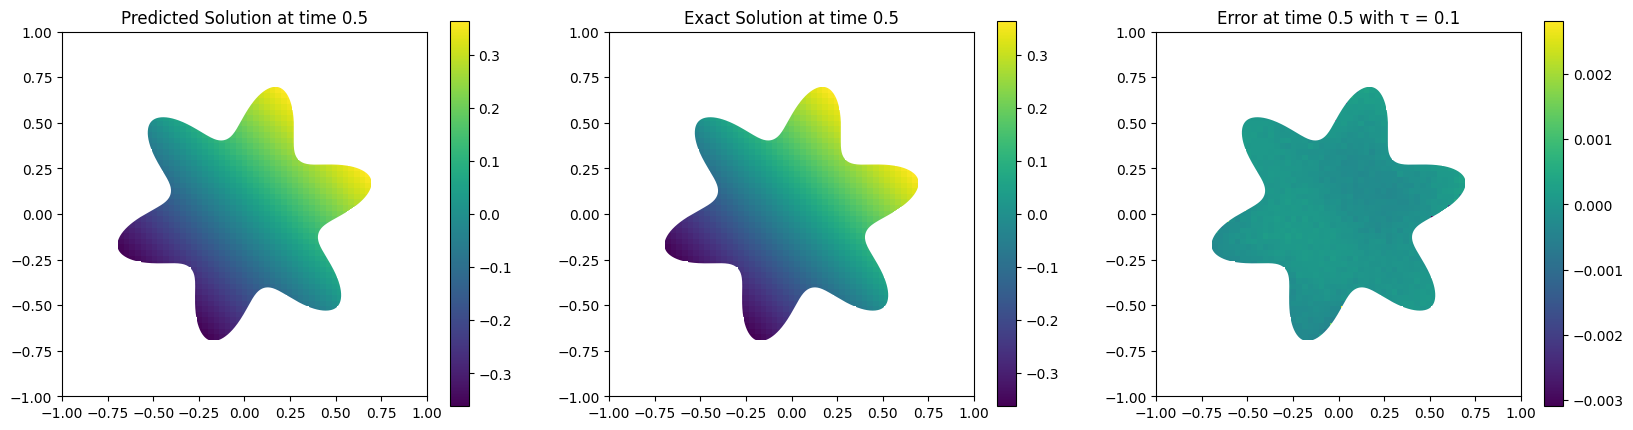

Absolute L2 Norm Error: 0.000131
Absolute Max Norm Error: 0.003097
Relative L2 Norm Error: 0.1357%
Relative Max Norm Error: 0.8540%


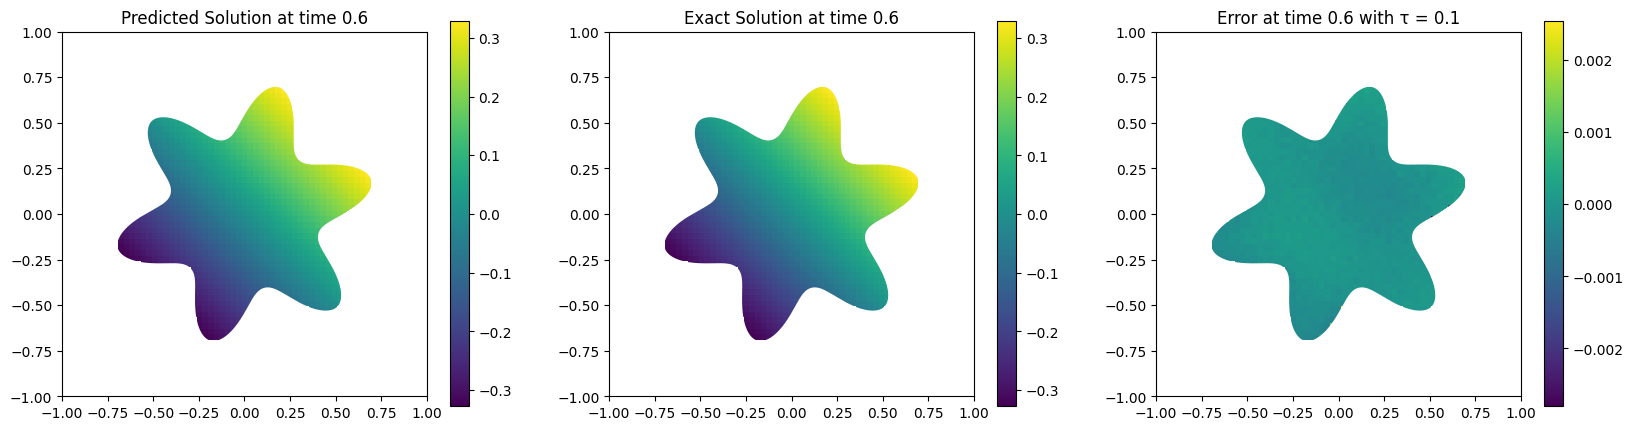

Absolute L2 Norm Error: 0.000119
Absolute Max Norm Error: 0.002805
Relative L2 Norm Error: 0.1361%
Relative Max Norm Error: 0.8549%


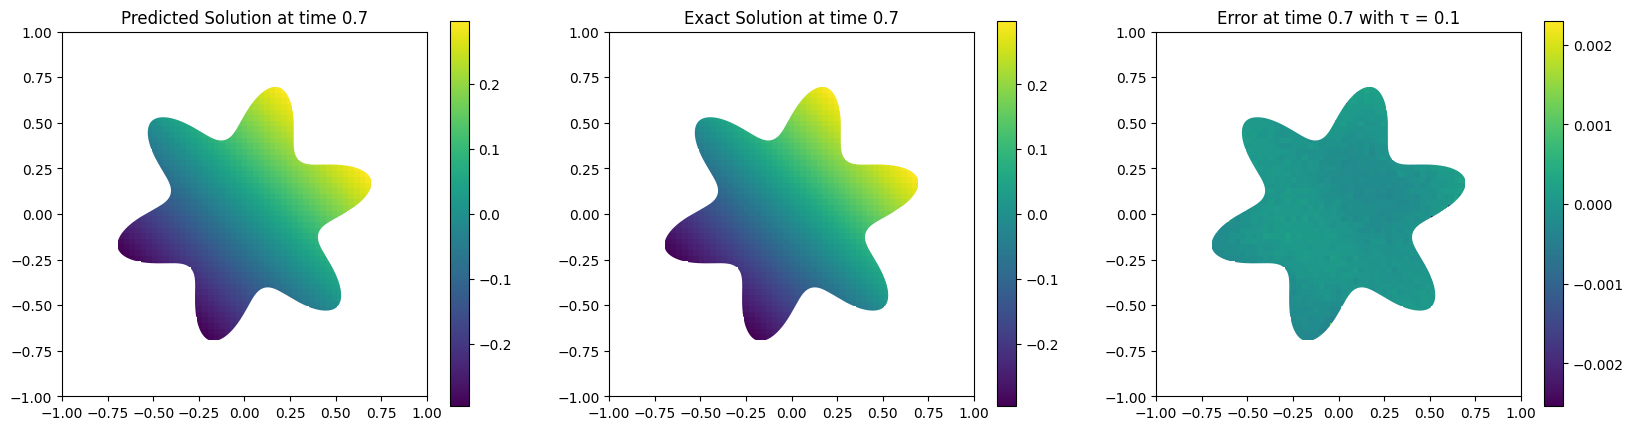

Absolute L2 Norm Error: 0.000108
Absolute Max Norm Error: 0.002541
Relative L2 Norm Error: 0.1365%
Relative Max Norm Error: 0.8559%


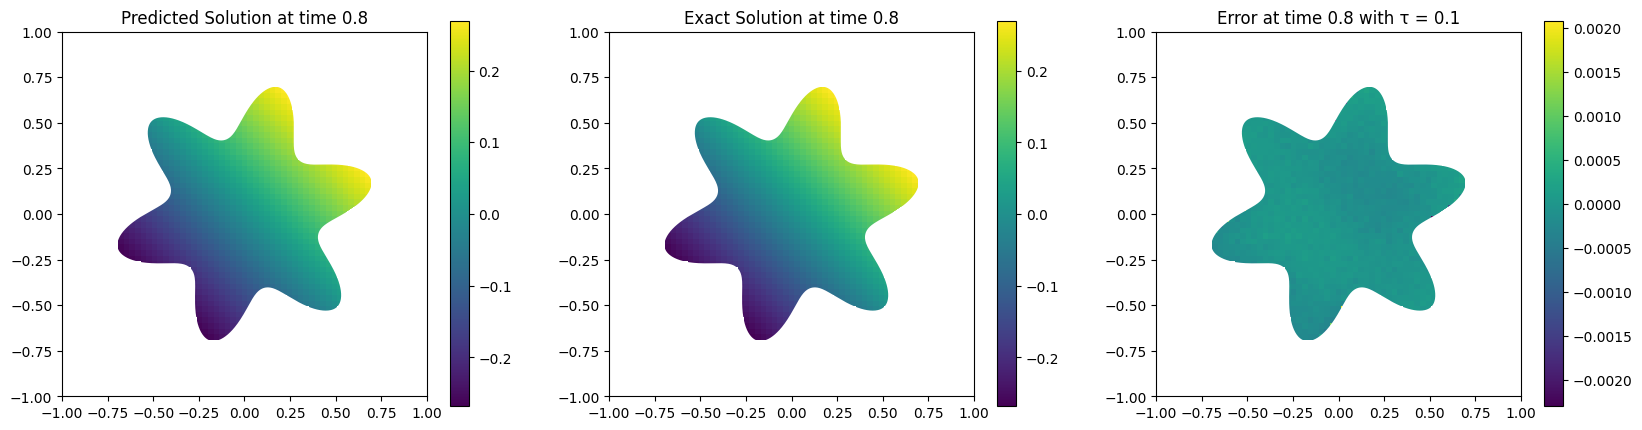

Absolute L2 Norm Error: 0.000098
Absolute Max Norm Error: 0.002302
Relative L2 Norm Error: 0.1369%
Relative Max Norm Error: 0.8570%


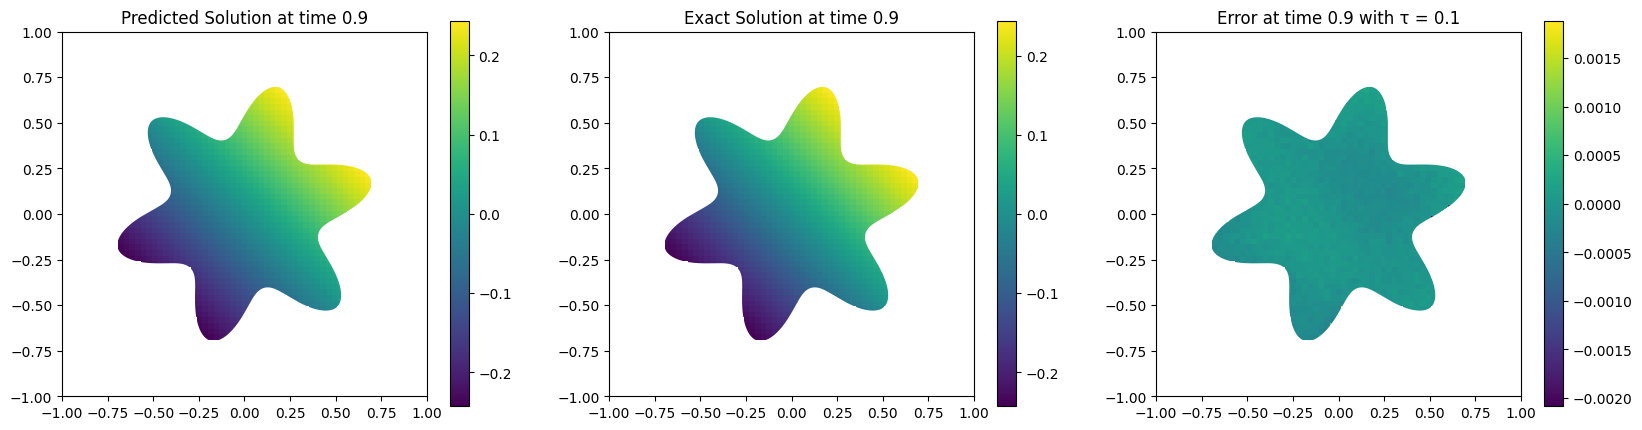

Absolute L2 Norm Error: 0.000089
Absolute Max Norm Error: 0.002086
Relative L2 Norm Error: 0.1375%
Relative Max Norm Error: 0.8583%


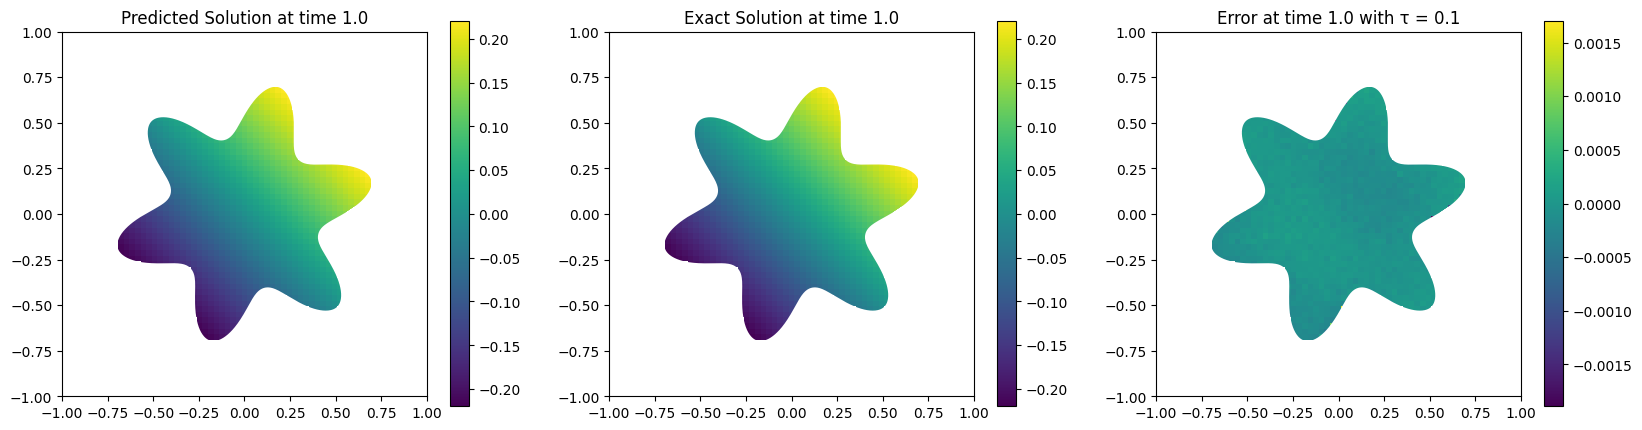

Absolute L2 Norm Error: 0.000081
Absolute Max Norm Error: 0.001891
Relative L2 Norm Error: 0.1382%
Relative Max Norm Error: 0.8596%


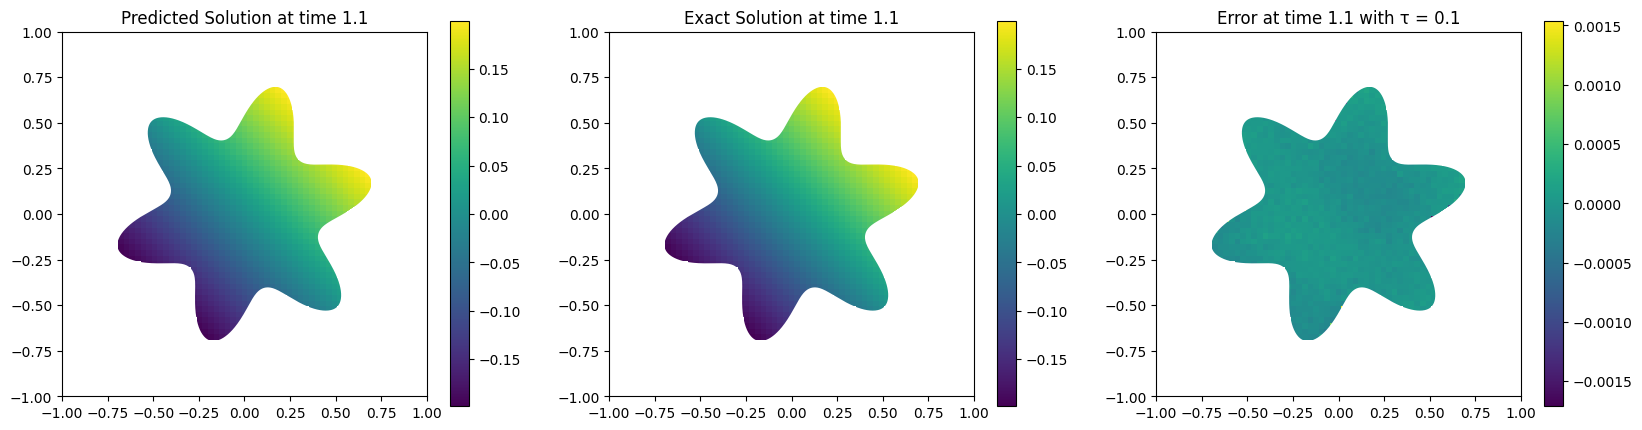

Absolute L2 Norm Error: 0.000074
Absolute Max Norm Error: 0.001714
Relative L2 Norm Error: 0.1390%
Relative Max Norm Error: 0.8611%


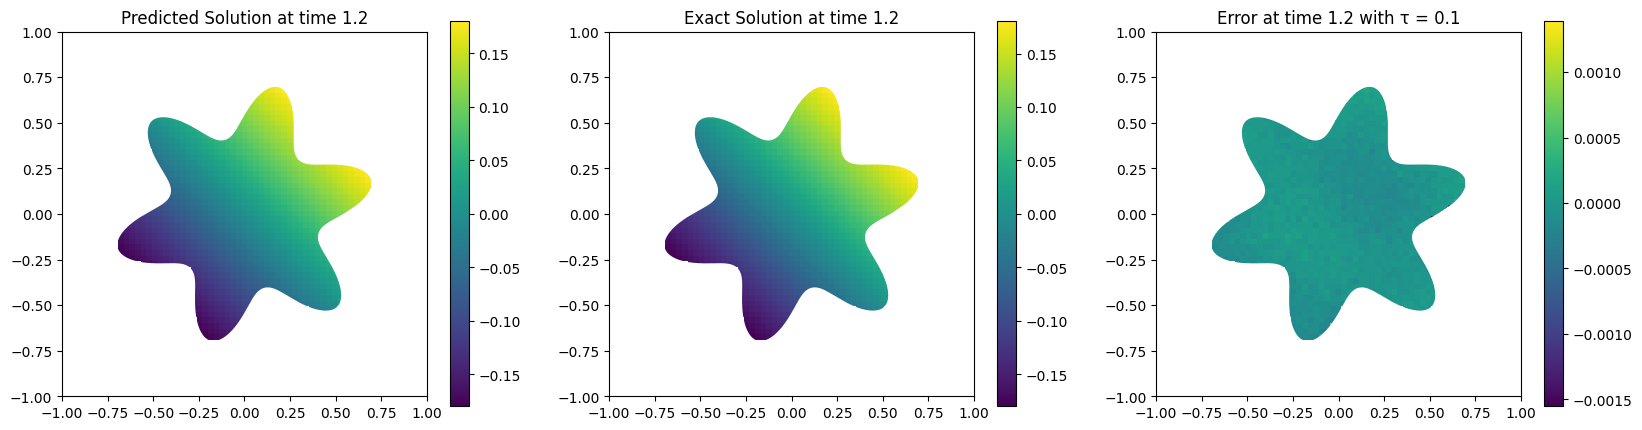

Absolute L2 Norm Error: 0.000067
Absolute Max Norm Error: 0.001554
Relative L2 Norm Error: 0.1400%
Relative Max Norm Error: 0.8628%


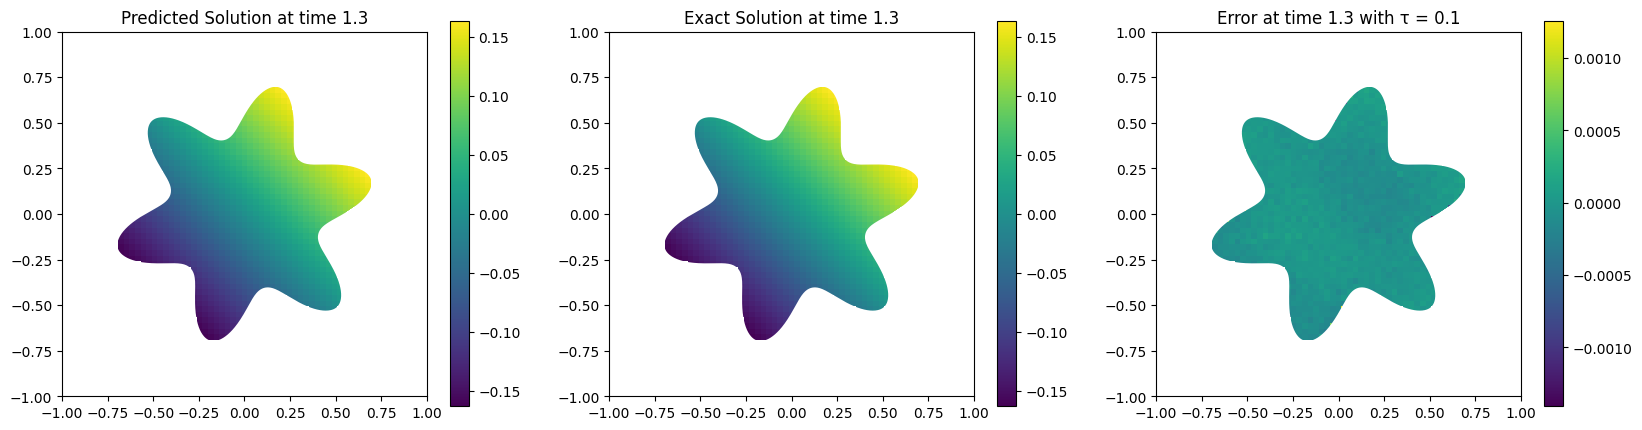

Absolute L2 Norm Error: 0.000061
Absolute Max Norm Error: 0.001409
Relative L2 Norm Error: 0.1412%
Relative Max Norm Error: 0.8647%


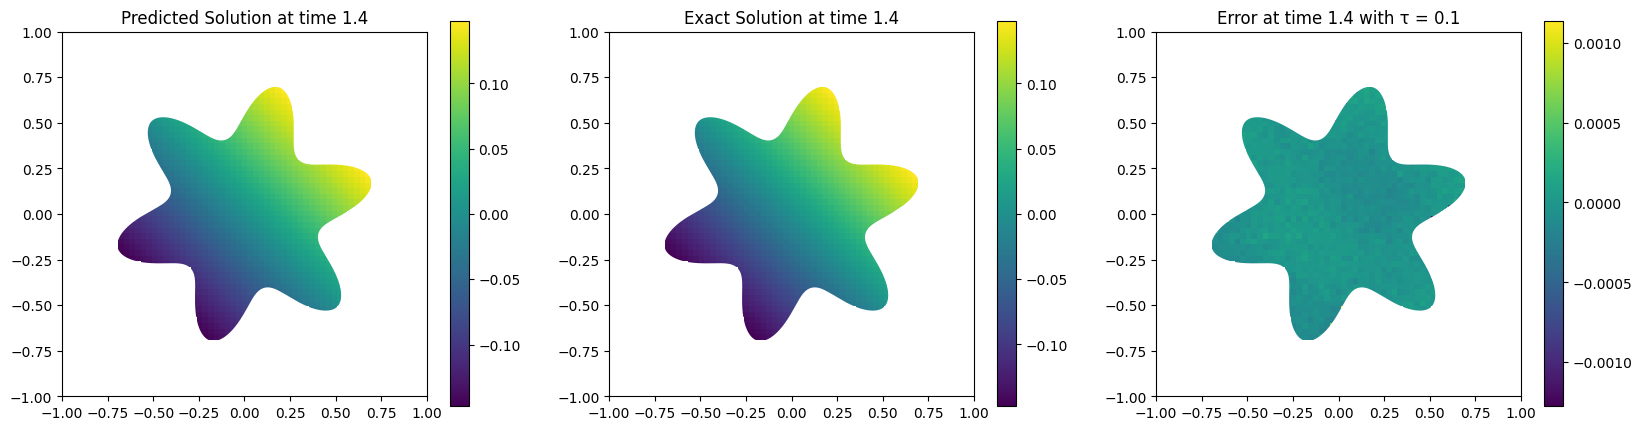

Absolute L2 Norm Error: 0.000056
Absolute Max Norm Error: 0.001278
Relative L2 Norm Error: 0.1427%
Relative Max Norm Error: 0.8667%


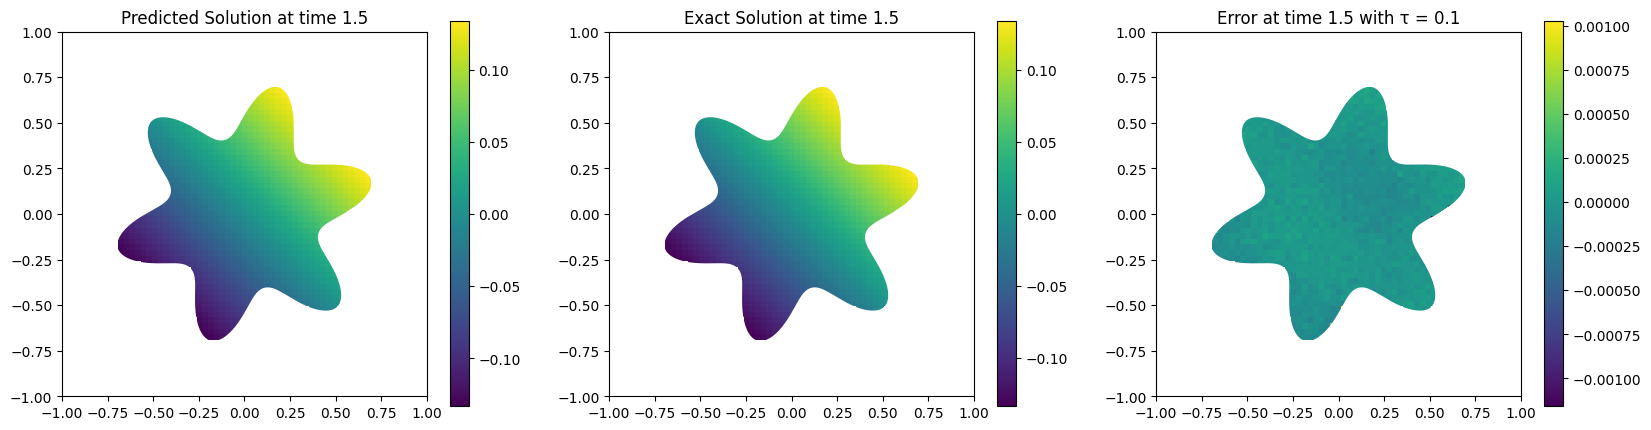

Absolute L2 Norm Error: 0.000051
Absolute Max Norm Error: 0.001159
Relative L2 Norm Error: 0.1445%
Relative Max Norm Error: 0.8690%


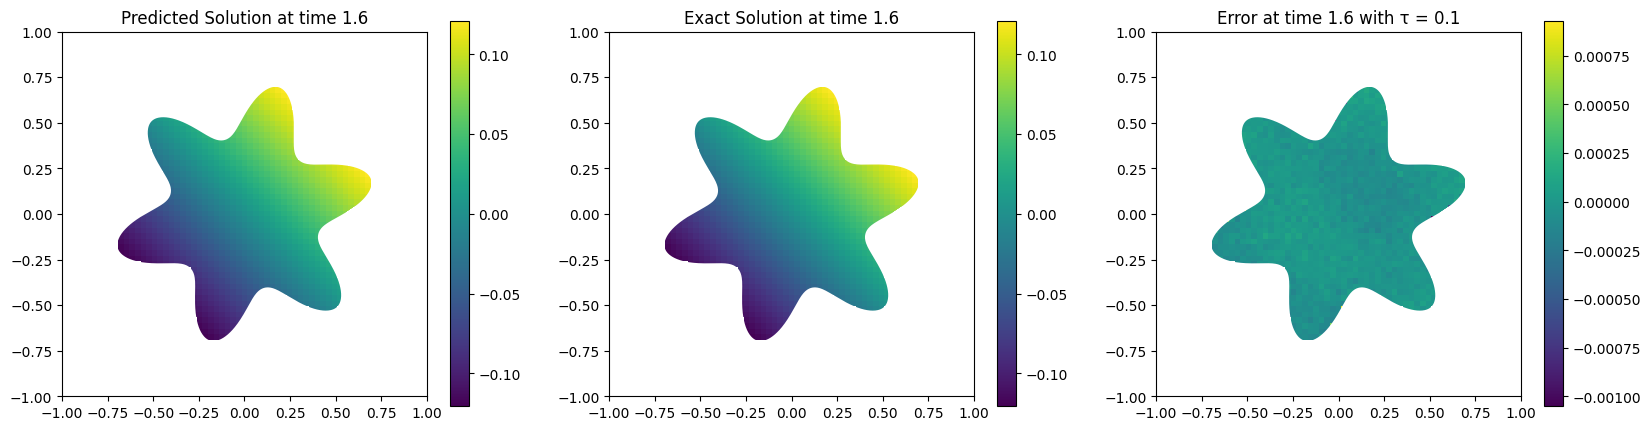

Absolute L2 Norm Error: 0.000047
Absolute Max Norm Error: 0.001052
Relative L2 Norm Error: 0.1466%
Relative Max Norm Error: 0.8715%


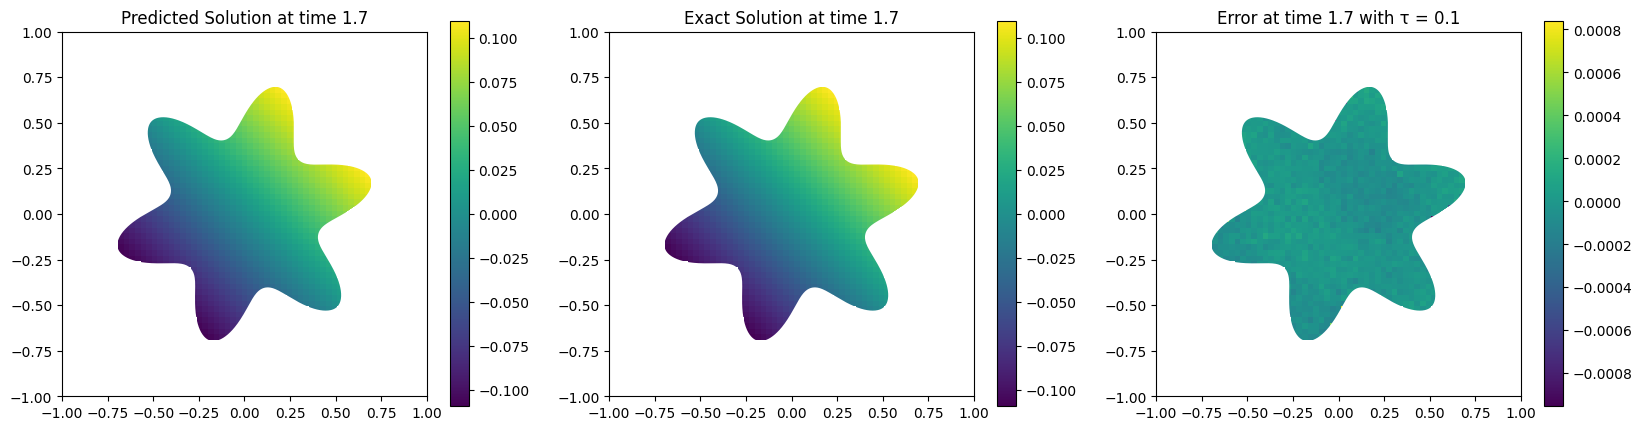

Absolute L2 Norm Error: 0.000043
Absolute Max Norm Error: 0.000955
Relative L2 Norm Error: 0.1493%
Relative Max Norm Error: 0.8742%


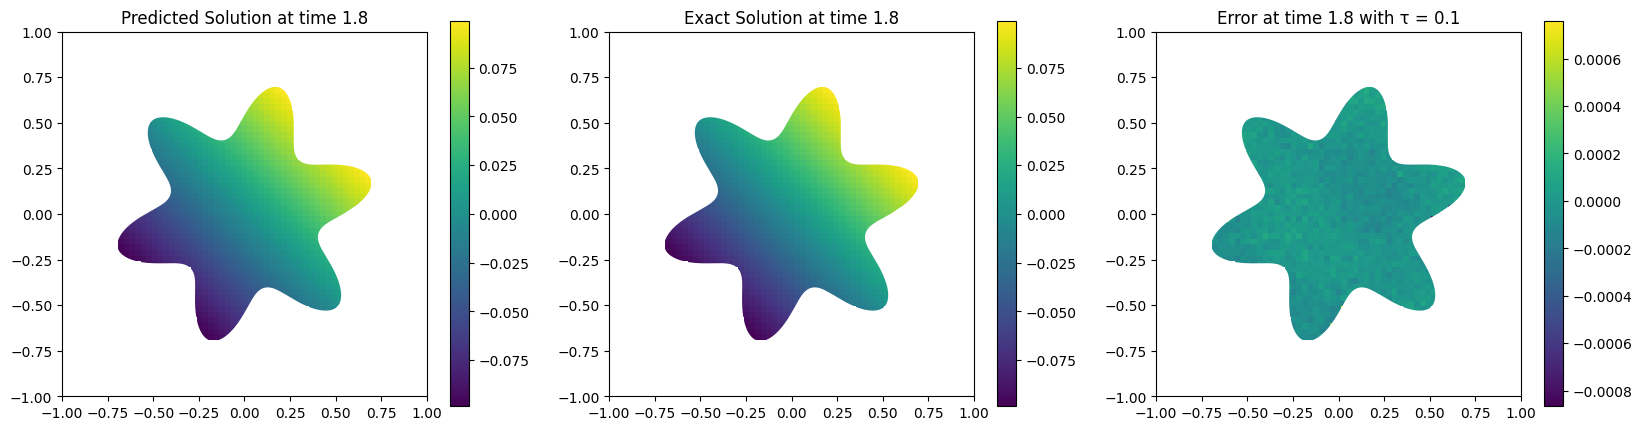

Absolute L2 Norm Error: 0.000040
Absolute Max Norm Error: 0.000867
Relative L2 Norm Error: 0.1524%
Relative Max Norm Error: 0.8772%


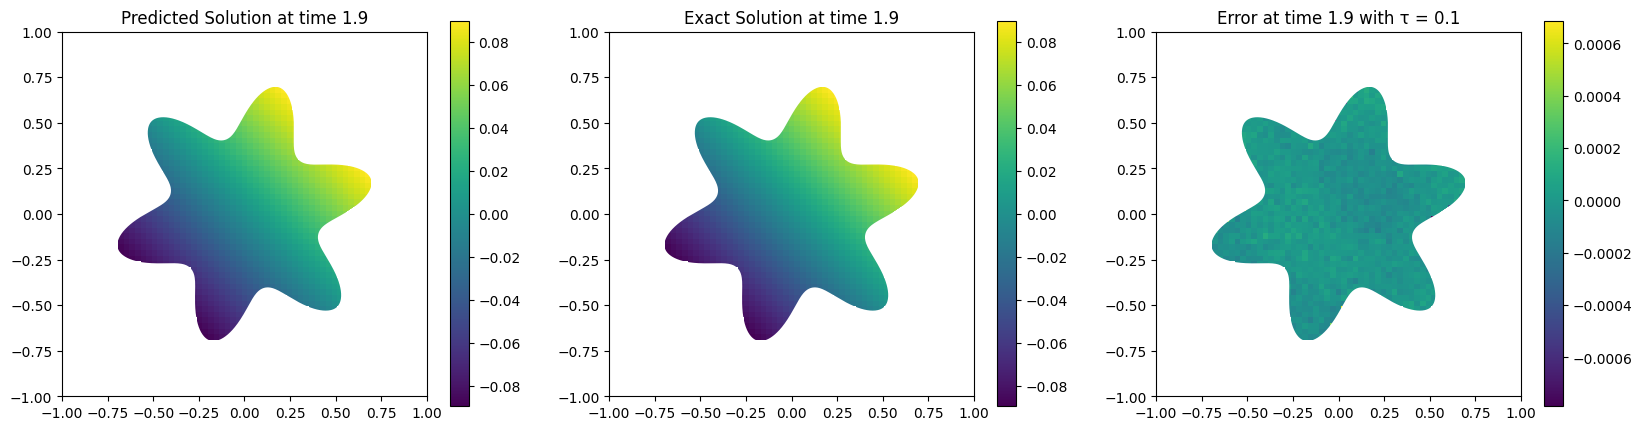

Absolute L2 Norm Error: 0.000037
Absolute Max Norm Error: 0.000787
Relative L2 Norm Error: 0.1561%
Relative Max Norm Error: 0.8806%


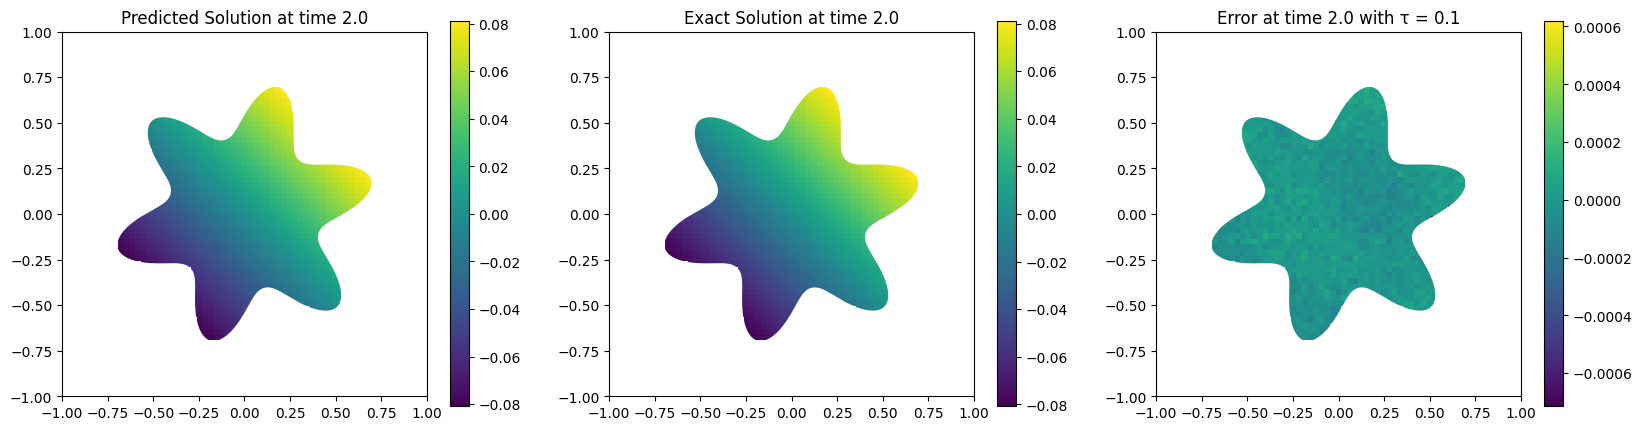

Absolute L2 Norm Error: 0.000035
Absolute Max Norm Error: 0.000716
Relative L2 Norm Error: 0.1606%
Relative Max Norm Error: 0.8843%


In [12]:
testNEKM(tau = 0.1, n = 20)